<a href="https://colab.research.google.com/github/amiraliz93/AI-in-Sport/blob/main/LSTM_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finpy_tse
!pip install mplfinance
!pip install yfinance

In [ ]:
#this is tech model by LSTM to able detet fake new and right news 
import re

import finpy_tse as tse
import mplfinance as mplf
import scipy.stats as stt

import os
import math
import datetime as dt
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import requests
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [ ]:
#bors iran
# DF1 = tse.Build_Market_StockList(bourse=True,
#                                  farabourse=True,
#                                  payeh=True,
#                                  detailed_list=False,
#                                  show_progress=True,
#                                  save_excel=False,
#                                  save_csv=False)
DF2 = tse.Get_CWI_History(start_date='1399-01-01',
                          end_date='1402-01-06',
                          ignore_date=False,
                          just_adj_close=False,
                          show_weekday=True,
                          double_date=True)

KeyboardInterrupt: ignored

In [ ]:
import yfinance as yf
# Get Stock Data by specifying in the format of (YYYY-MM-DD)
start = "2017-01-01-00:00:00"
end = "2023-03-19-00:00:00"
# Specify the stock tickers


# To retrieve multiple tickers, separate them with spaces
tickers = 'BTC-USD'

data = yf.download(tickers='BTC-USD', period='2y', interval='1h' )

df2 = data.copy()
# load dataset
dataset = df2.copy()
dataset = dataset.drop(columns=['Volume'])
values = dataset.values
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Datetime,,,,,
2021-03-24 16:00:00+00:00,56386.968750,56514.664062,56085.406250,56111.925781,56111.925781
2021-03-24 17:00:00+00:00,56105.835938,56572.953125,56036.855469,56465.261719,56465.261719
2021-03-24 18:00:00+00:00,56445.699219,56529.351562,55718.640625,55718.640625,55718.640625
2021-03-24 19:00:00+00:00,55695.425781,55695.425781,55001.957031,55008.976562,55008.976562
2021-03-24 20:00:00+00:00,55009.703125,55009.703125,53682.250000,54492.085938,54492.085938
...,...,...,...,...,...
2023-03-24 12:00:00+00:00,27647.933594,28116.009766,27613.341797,28016.763672,28016.763672
2023-03-24 13:00:00+00:00,28015.271484,28015.271484,27711.914062,27938.537109,27938.537109
2023-03-24 14:00:00+00:00,27972.609375,28208.205078,27870.269531,28028.796875,28028.796875


In [ ]:
dataset.shape

(17276, 5)

In [ ]:
count = 0
for index, value in enumerate(df2):
  if value == 0 or value == ' ':
    count += 1
print(count)

0


In [ ]:
# convert series  to supervise
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
 names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 if i == 0:
  names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
  names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg


 # ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# specify the number of lag hours
n_hours = 1
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# # drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.769212,0.768590,0.765684,0.763814,0.763814,0.763904
2,0.763904,0.769689,0.764765,0.770485,0.770485,0.770321
3,0.770321,0.768867,0.758747,0.756390,0.756390,0.756155
4,0.756155,0.753146,0.745193,0.742992,0.742992,0.743207
5,0.743207,0.740218,0.720235,0.733234,0.733234,0.732952
...,...,...,...,...,...,...
17271,0.234374,0.233118,0.225861,0.226599,0.226599,0.226585
17272,0.226585,0.233213,0.227216,0.233415,0.233415,0.233521
17273,0.233521,0.231314,0.229080,0.231938,0.231938,0.232716
17274,0.232716,0.234951,0.232075,0.233642,0.233642,0.233608


In [ ]:
reframed.shape

(17275, 6)

In [ ]:
# split data to train and test

values2 = reframed.values
N_train = int(17291 * 0.73) # the number 
train = values2[:N_train, :]
test = values2[N_train:, :]

#split to input and output
x_train, y_train = train[:, :-1], train[:, 1]
x_test, y_test = test[:, :-1], test[:, 1]

# change the 2D to #d as we need for LSTM [samples, timesteps, features]
# Samples: One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(12622, 1, 5) (12622,) (4653, 1, 5) (4653,)


In [ ]:
model = Sequential()
model.add(LSTM(50 , input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

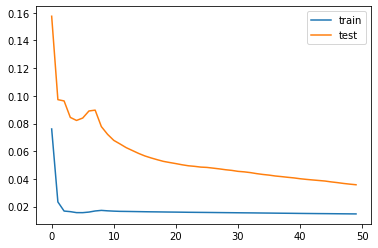

In [ ]:
history = model.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_train, y_train), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make prediction
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
y_predic = model.predict(x_test)
# reshape our x_test and y_predit to initial frame
x_test1 = x_test.reshape((x_test.shape[0], x_test.shape[2]))
# predic to initial shape
y_forcast1 = concatenate((y_predic, x_test1[:, 1:]), axis=1)

y_forcast1 = scaler.inverse_transform(y_forcast1)
inv_forcast = y_forcast1[:,0]

146/146 [==============================] - 1s 2ms/step


array([21418.553, 21426.623, 21444.049, ..., 26399.129, 26414.451,
       26494.215], dtype=float32)

In [ ]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
y_test = concatenate((y_test, x_test1[:, 1:]), axis=1)
y_test = scaler.inverse_transform(y_test)
inv_y = y_test[:,0]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_forcast))
print('Test RMSE model3: %.3f' % rmse)

Test RMSE model3: 448.241


In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, y_forcast1))
print('Test RMSE model2: %.3f' % rmse)

Test RMSE model2: 196.448


In [ ]:
RMSE_N = rmse/ (max(inv_y) - min(inv_y))
RMSE_N

0.034379923219870205

<ipython-input-54-05aa4e6e1df8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = inv_forcast


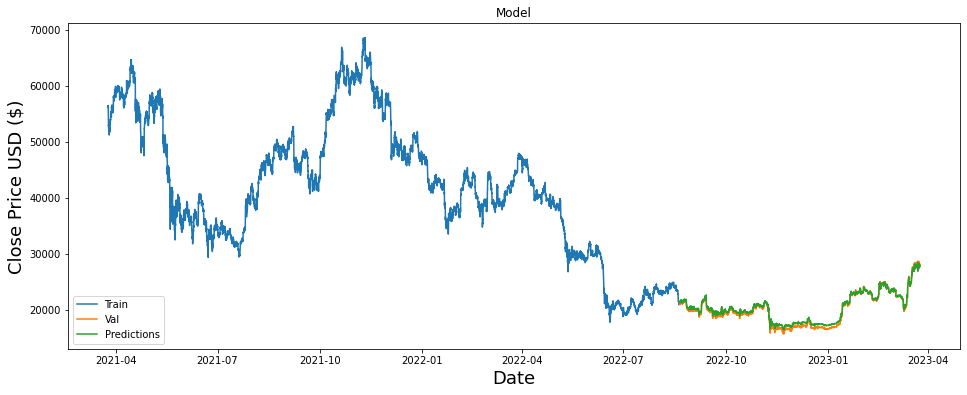

In [ ]:
# Plot the data
train = dataset[:N_train]
valid = dataset[N_train:-1]
valid['Predictions'] = inv_forcast
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')
plt.show()

# Forcast

In [ ]:
seed_input = x_test[-1]
seed_input.shape

(1, 5)

In [ ]:
seed_input = x_test[-1]
pre = []
x_end = x_test[-1:, :, :]  # Last time step of training data
x_new = []
predict = []
for i in range(10):

    seed_input = seed_input.reshape((1, 1, seed_input.shape[0]))
    print(seed_input)
    predicted = model.predict(seed_input, verbose=0)
    pre.append(predicted[0,0])
    predicted = predicted.reshape((1, 1, predicted.shape[1]))
    
    seed_input = np.append(seed_input[:, :, 1:], predicted, axis=2)

ValueError: ignored

In [ ]:
# extract the predicted values
y_test = y_test.reshape((len(y_test), 1))
pre_vale = np.array(pre)
pre_vale = pre_vale.reshape(-1,1)
y_forcast = np.concatenate([y_test[-10:], pre_vale])


In [ ]:
y_forcast = scaler.inverse_transform(y_forcast)
y_forcast

<ipython-input-79-979b12c3c294>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_forcast


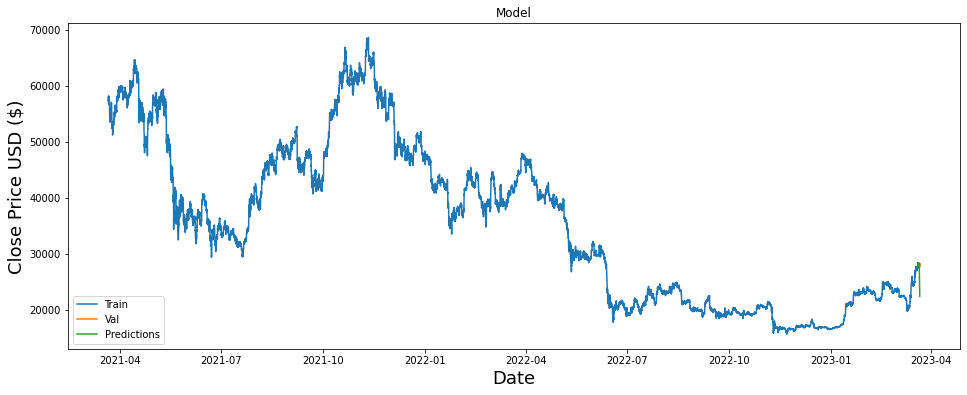

In [ ]:
# Plot the data
train = dataset
valid = dataset[-21:-1]
valid['Predictions'] = y_forcast
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')
plt.show()